In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K
import xgboost as xgb
import os

from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout, Conv1D, MaxPooling1D, Convolution1D,\
                         Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM,TimeDistributed, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

In [2]:
# X_training = pickle.load(open("X_train.pickle","rb"))
# Y_training = pickle.load(open("Y_train.pickle","rb"))
# X_testing = pickle.load(open("X_test.pickle","rb"))
# Y_testing = pickle.load(open("Y_test.pickle","rb"))

# X_training_un = pickle.load(open("X_train_un.pickle","rb"))
# Y_training_un = pickle.load(open("Y_train_un.pickle","rb"))
# X_testing_un = pickle.load(open("X_test_un.pickle","rb"))
# Y_testing_un = pickle.load(open("Y_test_un.pickle","rb"))


data_dir = '../data2/5dBsim'

X_training = np.load(os.path.join(data_dir, "X_train.npy"))#"../data2/X_train_f100.npy")
Y_training = np.load(os.path.join(data_dir, "Y_train.npy"))#"../data2/Y_train_f100.npy")

X_val = np.load(os.path.join(data_dir, "X_val.npy"))#"../data2/X_val_f100.npy")
Y_val = np.load(os.path.join(data_dir, "Y_val.npy"))#"../data2/Y_val_f100.npy")

X_testing = np.load(os.path.join(data_dir, "X_test.npy"))#"../data2/X_test_f100.npy")
Y_testing = np.load(os.path.join(data_dir, "Y_test.npy"))#"../data2/Y_test_f100.npy")

# X_training_un = pickle.load(open("X_train_un.pickle","rb"))
# Y_training_un = pickle.load(open("Y_train_un.pickle","rb"))
# X_testing_un = pickle.load(open("X_test_un.pickle","rb"))
# Y_testing_un = pickle.load(open("Y_test_un.pickle","rb"))


# X_training = np.concatenate((X_training, X_training_un), axis=0)
# Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
# X_val = X_testing
# Y_val = Y_testing
# X_testing = np.concatenate((X_testing, X_testing_un), axis=0)
# Y_testing = np.concatenate((Y_testing, Y_testing_un), axis=0)


# Centering and Normalizing data


# X_training = X_training[0:10]
# Y_training = Y_training[0:10]

mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

In [15]:
X_testing.shape

(2000, 16, 201, 2)

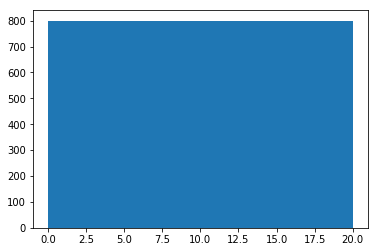

In [3]:
plt.hist(Y_training)
plt.show()

In [28]:
def get_model(batch_size, data_dim = 100):
    nb_filters = 200
#     model = Sequential()
#     model.add(Conv1D(input_shape = (data_dim, 1), filters = nb_filters, 
#                      kernel_size = 10, activation='tanh', name="Conv1"))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters = nb_filters, kernel_size = 5, 
#                      activation='relu', name="Conv2"))
#     model.add(Flatten())
#     model.add(Dense(2048, activation='relu', name="Dense1"))
#     model.add(Dropout(0.2))
#     model.add(Dense(1024, activation='relu', name="Dense2"))
#     model.add(Dense(1))
    
#     inputs = Input(shape = (data_dim, 1))
#     conv_1 = Convolution1D(filters = 512, kernel_size = 16,
#                     activation='tanh', name="Conv1")(inputs)
#     maxpool_1 = MaxPooling1D(name="maxpool1")(conv_1)
# #     batch_norm1 = BatchNormalization( name = "batch_norm_1")(maxpool_1)
#     conv_2 = Convolution1D(filters = 256, kernel_size = 8, 
#                      activation='relu', name="Conv2")(maxpool_1)
#     maxpool_2 = MaxPooling1D(name="maxpool2")(conv_2)
# #     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
#     conv_3 = Convolution1D(filters = nb_filters, kernel_size = 2, 
#                      activation='relu', name="Conv3")(maxpool_2)
#     maxpool_3 = MaxPooling1D(name="maxpool3")(conv_3)
# #     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
#     flatten = Flatten()(maxpool_2)
#     dense_1 = Dense(1024, activation='relu', name="Dense1")(flatten)
# #     dropout_1 = Dropout(0.2)(dense_1)
#     dense_2 = Dense(512, activation='relu', name="Dense2")(dense_1)
# #     dropout_1 = Dropout(0.2)(dense_2)
#     output = Dense(1, name="output")(dense_2)
#     model = Model(inputs = inputs, output = output)

    inputs = Input(shape = (16,201,2))
    conv_1 = Convolution2D(filters = 512, kernel_size = (7,7),
                    activation='tanh', name="Conv1")(inputs)
    maxpool_1 = MaxPooling2D(name="maxpool1")(conv_1)
#     batch_norm1 = BatchNormalization( name = "batch_norm_1")(maxpool_1)
    conv_2 = Convolution2D(filters = 256, kernel_size = (3,3), 
                     activation='relu', name="Conv2")(conv_1)
    maxpool_2 = MaxPooling2D(name="maxpool2")(conv_2)
#     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
    conv_3 = Convolution2D(filters = nb_filters, kernel_size = (3,3), 
                     activation='relu', name="Conv3")(conv_2)
    maxpool_3 = MaxPooling2D(name="maxpool3")(conv_3)
#     batch_norm2 = BatchNormalization( name = "batch_norm_2")(maxpool_2)
    
    flatten = Flatten()(maxpool_3)
    dense_1 = Dense(1024, activation='relu', name="Dense1")(flatten)
#     dropout_1 = Dropout(0.2)(dense_1)
    dense_2 = Dense(512, activation='relu', name="Dense2")(dense_1)
#     dropout_1 = Dropout(0.2)(dense_2)
    output = Dense(1, name="output")(dense_2)
    model = Model(inputs = inputs, output = output)
    
    return model

In [29]:
n_epochs = 50
data_dim = X_training.shape[1]
batch_size = 20
L=len(X_training)
n_Iter = int(L/batch_size)

optimizer = optimizers.Adadelta()#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(batch_size, data_dim)
model.compile(loss="mse", optimizer=optimizer)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4,
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
# val_data = (np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)), Y_val)
# Y_train = np.reshape( Y_training, (L, 1, 1) )
# X_train = np.reshape( X_training, (L, X_training.shape[1], 1) )

/home/akpurohi/.conda/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 16, 201, 2)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 10, 195, 512)      50688     
_________________________________________________________________
Conv2 (Conv2D)               (None, 8, 193, 256)       1179904   
_________________________________________________________________
Conv3 (Conv2D)               (None, 6, 191, 200)       461000    
_________________________________________________________________
maxpool3 (MaxPooling2D)      (None, 3, 95, 200)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57000)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 1024)              58369024  
__________

In [32]:
model.fit(x=X_training, y=Y_training, batch_size=batch_size, epochs=n_epochs, 
          validation_split=0.3
#           validation_data=(X_testing, Y_testing), 
          callbacks=callbacks_list)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 626s 78ms/step - loss: 47.4750 - val_loss: 89.6519
Epoch 2/50
8000/8000 [==============================] - 595s 74ms/step - loss: 9.3351 - val_loss: 51.7662
Epoch 3/50
8000/8000 [==============================] - 575s 72ms/step - loss: 5.1587 - val_loss: 35.1432
Epoch 4/50
8000/8000 [==============================] - 595s 74ms/step - loss: 3.9732 - val_loss: 36.3527
Epoch 5/50
8000/8000 [==============================] - 590s 74ms/step - loss: 2.9865 - val_loss: 42.5397
Epoch 6/50
8000/8000 [==============================] - 600s 75ms/step - loss: 2.6056 - val_loss: 34.1426
Epoch 7/50
8000/8000 [==============================] - 601s 75ms/step - loss: 1.9008 - val_loss: 37.9561
Epoch 8/50
8000/8000 [==============================] - 603s 75ms/step - loss: 2.2667 - val_loss: 29.0981
Epoch 9/50
8000/8000 [==============================] - 600s 75ms/step - loss: 1.5258 - val_loss: 22.85

In [6]:
# # Save model
# model.save('model_1D_CNN.h5')

# Load saved model
# model = load_model('model_mlp_time_data.h5')

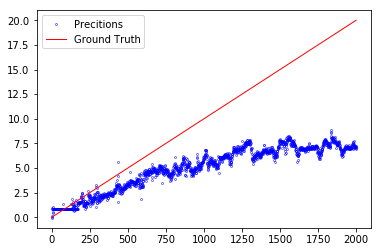

Test RMSE: 6.270868870590939


In [35]:
# 100 components, full data, n_estimators = 100, reg:gamma
# preds = model.predict(np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)))
# rmse = np.sqrt(mean_squared_error(preds, Y_val)) #np.sqrt(np.mean((preds-Y_testing)**2))
# print("Val RMSE:", rmse)

preds = model.predict(X_testing)#np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1)))
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_testing,'r',linewidth=1.0)
plt.legend(['Precitions', 'Ground Truth'])
plt.show()

rmse = np.sqrt(mean_squared_error(preds, Y_testing)) #np.sqrt(np.mean((preds-Y_testing)**2))
print("Test RMSE:", rmse)

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_1D_CNN.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.